In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math

In [2]:
# Load data from CSV file
data = pd.read_csv('PVS Historical Data.csv',index_col='Date', parse_dates=True)
data = data.sort_index()

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-15,17656.0,17292.0,17929.0,17292.0,6370000,0.0104
2017-12-18,19021.0,17747.0,19385.0,17747.0,15170000,0.0773
2017-12-19,19385.0,19112.0,19658.0,18839.0,9390000,0.0191
2017-12-20,20022.0,19385.0,21206.0,19385.0,12970000,0.0329
2017-12-21,20114.0,20296.0,20660.0,19750.0,10970000,0.0046
...,...,...,...,...,...,...
2023-06-09,30600.0,30800.0,30900.0,30200.0,6000000,0.0000
2023-06-12,30900.0,30600.0,30900.0,29900.0,7450000,0.0098
2023-06-13,30900.0,30900.0,31200.0,30500.0,6010000,0.0000


Text(0, 0.5, 'Prices ($)')

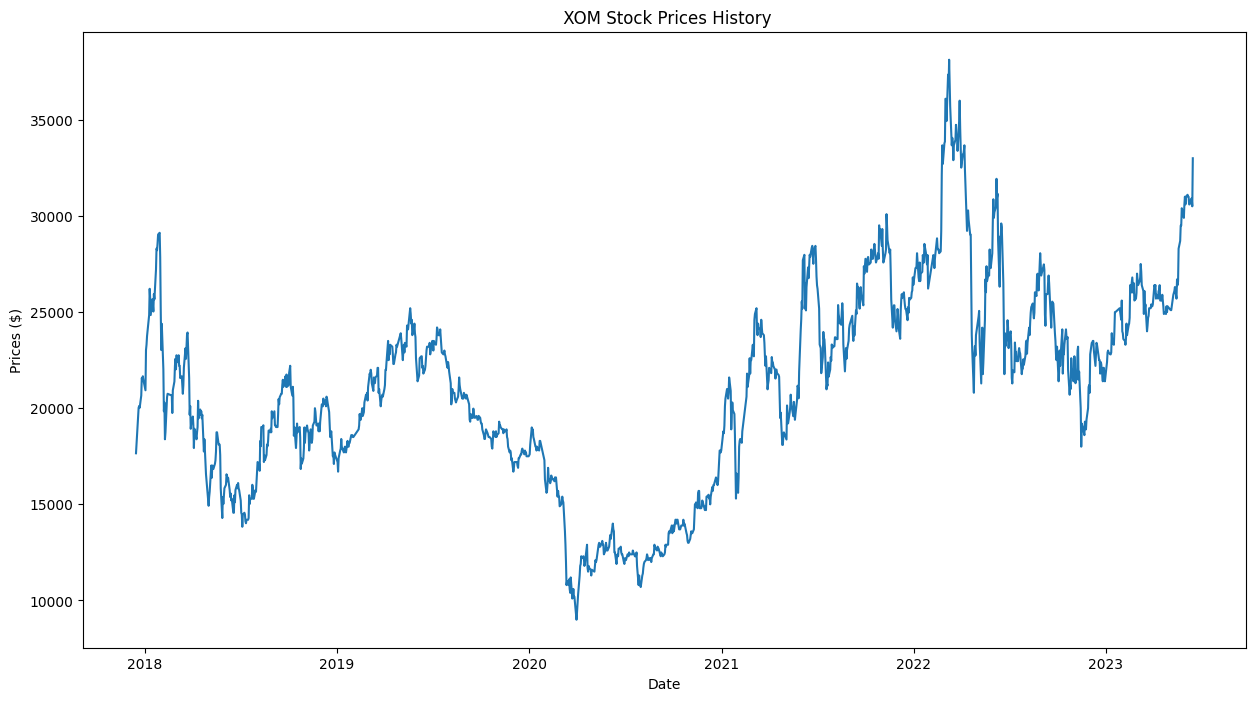

In [3]:
plt.figure(figsize=(15, 8))
plt.title(' XOM Stock Prices History')
plt.plot(data['Price'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [4]:
from numpy import linalg as la
import statistics as stat
from scipy.special import ndtri
from scipy.stats import norm
import random
from sklearn.metrics import mean_squared_error

In [5]:
close_prices = data['Price']
values = close_prices.values

train_size = int(len(close_prices) * 0.75)
test_size = int(len(close_prices) * 0.15)
val_size = len(close_prices) - train_size - test_size

train_data = values[:train_size]
test_data = values[train_size:train_size+test_size]
val_data = values[train_size+test_size:]

**MCMC**

In [6]:
mu, sig, N = 1.1, 1, 100000
pts = []

*In a normal distribution, **mu** represents the mean, **sig** represents
the standard deviation, and **N** represents the number of samples.*

In [7]:
def q(x):
    return (1 / (math.sqrt(2 * math.pi * sig ** 2))) * (math.e ** (-((x - mu) ** 2) / (2 * sig ** 2)))

def MCMC(n):
    r = np.zeros(1)
    p = q(r[0])
    pts = []

    for i in range(N):
        rn = r + np.random.uniform(-1, 1)
        pn = q(rn[0])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn / p:
                p = pn
                r = rn
        pts.append(r)

    pts = random.sample(pts, len(pts))
    pts = np.array(pts)

    return pts

In [8]:
stock_pred = []

maturnity = 1
volatility = 0.25
risk_free = 0.1
timestep = 1
steps = test_size + val_size
delta_t = maturnity / steps
i = 0
stock_pred.append(train_data[-1])
while timestep < steps:
  stock_price = stock_pred[-i]
  time_exp = maturnity - delta_t * timestep
  # Generate z_t using MCMC method
  pts = MCMC(N)
  stock_price = stock_price * math.exp(((risk_free - 0.5 * (math.pow(volatility, 2))) * delta_t + volatility * math.sqrt(delta_t) * pts[timestep + 5]))
  stock_pred.append(stock_price)
  i = i + 1
  timestep = timestep + 1



*   Evaluate the algorithm's accuracy using RMSE, MAPE, MDA



In [13]:
test_data = np.array(test_data)
val_data = np.array(val_data)

In [14]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((val_data - stock_pred[test_size:]) ** 2))
test_rmse = np.sqrt(np.mean((test_data - stock_pred[:test_size]) ** 2))
valid_mape = calculate_mape(val_data, stock_pred[test_size:])
test_mape = calculate_mape(test_data, stock_pred[:test_size])
valid_mda = calculate_mda(val_data, stock_pred[test_size:])
test_mda = calculate_mda(test_data, stock_pred[:test_size])

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 4600.560074777873
Testing RMSE: 5193.6023873709955
Validation MAPE: 17.320714023727714
Testing MAPE: 18.667902103652985
Validation MDA: 52.55474452554745
Testing MDA: 43.627450980392155


**VISUALIZATION OF PREDICTIONS**



*   Plot 1



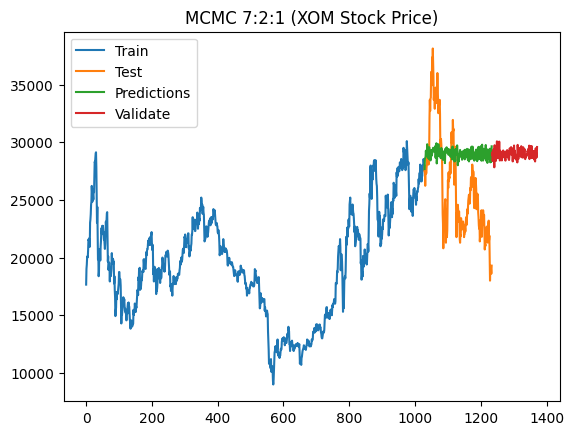

In [15]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data)

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=len(close_prices), step=1)

plt.plot(test_data_index,test_data)
plt.plot(test_data_index,stock_pred[:test_size])

# plt.plot(val_data_index,val_data)
plt.plot(val_data_index,stock_pred[test_size:])

plt.title('MCMC 7:2:1 (XOM Stock Price)')
plt.legend(['Train','Test','Predictions', 'Validate'])
plt.show()



*   Plot 2



In [17]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=train_data, mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=test_data, mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=stock_pred[:test_size], mode='lines+markers', marker=dict(size=4), name='Predictions', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=stock_pred[test_size:], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))

fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),
                  title_text = f'MCMC 7.5:1.5:1 (PVS Stock Price)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()